In [1]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')



**Use dataset: https://www.kaggle.com/datasets/iamtapendu/chest-x-ray-lungs-segmentation

In [2]:
print(os.listdir('.'))

['.DS_Store', 'training-u-net.ipynb', 'Chest-X-Ray', '.ipynb_checkpoints']


In [4]:
print(os.listdir('Chest-X-Ray/Chest-X-Ray'))

['image', 'mask', 'MetaData.csv']


In [5]:
img_path = os.path.join('Chest-X-Ray/Chest-X-Ray/image')
img_mask = os.path.join('Chest-X-Ray/Chest-X-Ray/mask')

In [6]:
print(f"Total Number of Images: {len(os.listdir(img_path))}")
print(f"Total Number of Masks: {len(os.listdir(img_mask))}")

Total Number of Images: 704
Total Number of Masks: 704


In [7]:
images_ds = [(os.path.join(img_path,img)) for img in os.listdir(img_path)]
mask_ds = [(os.path.join(img_mask,img)) for img in os.listdir(img_mask)]

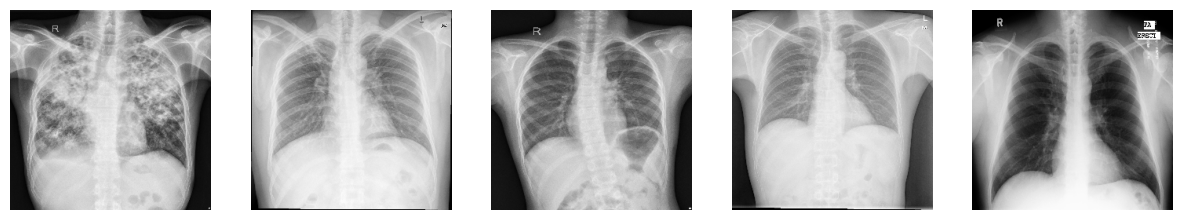

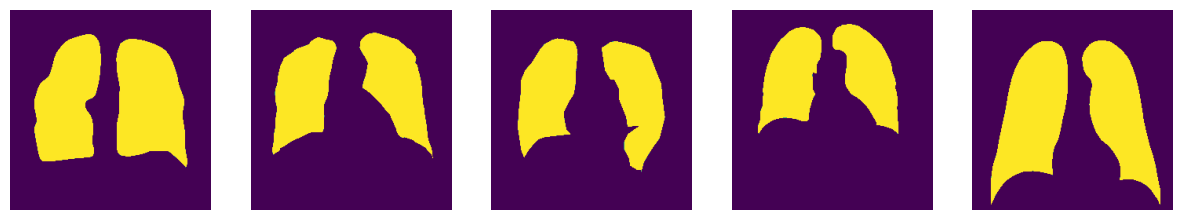

In [8]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))  # Create 1 row, 5 columns

for i, img in enumerate(images_ds[:5]):
    image = cv2.imread(img)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image_rgb, (256, 256))
    ax[i].imshow(image)
    ax[i].axis("off")

plt.show()


# Mask Images
fig, ax = plt.subplots(1, 5, figsize=(15, 5))  # Create 1 row, 5 columns

for i, img in enumerate(mask_ds[:5]):
    image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256))
    ax[i].imshow(image)
    ax[i].axis("off")

plt.show()

In [11]:
df_metadata = pd.read_csv('Chest-X-Ray/Chest-X-Ray/MetaData.csv')
df_metadata.head()

,id,gender,age,county,ptb,remarks
0,1000,male,31,Shenxhen,0,normal
1,1001,male,64,Shenxhen,0,normal
2,1002,male,35,Shenxhen,0,normal
3,1003,male,32,Shenxhen,1,"STB,ATB,tuberculosis pleuritis"
4,1004,male,2,Shenxhen,1,secondary PTB in the bilateral upper field


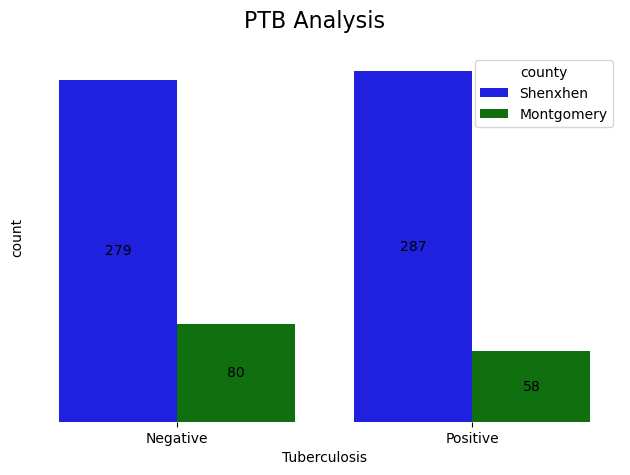

In [12]:
agg_data = df_metadata['ptb'].value_counts()
ct = pd.crosstab(df_metadata['gender'], df_metadata['ptb'])


bars = sns.countplot(df_metadata,x='ptb',hue='county',palette=['b','g'])
plt.bar_label(bars.containers[0], label_type='center')
plt.bar_label(bars.containers[1], label_type='center')
plt.yticks([])
plt.xticks([0,1],labels=['Negative','Positive'])
plt.xlabel('Tuberculosis')
plt.box(False)

plt.suptitle('PTB Analysis',fontsize=16)
plt.tight_layout()
plt.show()


In [13]:
import albumentations as A

img_paths = images_ds  # list of image file paths
img_mask = mask_ds  # list of mask file paths

dataset = tf.data.Dataset.from_tensor_slices((img_paths, img_mask))


data_augmentation = A.Compose(
    [
        A.HorizontalFlip(p=0.5),  # Symmetry-safe
        A.RandomBrightnessContrast(p=0.2),  # Imaging variance
        A.GaussianBlur(p=0.1),  # Simulate machine blur
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.1),
        A.Resize(256, 256),  # Final resize
    ]
)

In [14]:
# Custom preprocessing function to read, resize, augment, and normalize images and masks
def preprocess_images(img_path, mask_path):
    # decode
    img_path = img_path.decode("utf-8")
    mask_path = mask_path.decode("utf-8")

    # Read and resize the input image using OpenCV
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV читає в BGR
    image = cv2.resize(image, (256, 256))

    # Load the masks
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = np.expand_dims(mask, axis=-1)

    # # Apply augmentations
    augmented = data_augmentation(image=image, mask=mask)
    image = augmented["image"] / 255.0
    mask = augmented["mask"] / 255.0


    return image.astype(np.float32), mask.astype(np.float32)

# TensorFlow wrapper to call the NumPy-based preprocessing function
def augment_images(img_path, mask_path):
    image, mask = tf.numpy_function(
        func=preprocess_images,
        inp=[img_path, mask_path],
        Tout=[tf.float32, tf.float32],
    )
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])
    return image, mask

# Create a tf.data.Dataset pipeline
dataset = tf.data.Dataset.from_tensor_slices((images_ds, mask_ds))
dataset = dataset.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle dataset
# Batch size of 16
# Prefetch for performance
dataset = dataset.shuffle(100).batch(16).prefetch(tf.data.AUTOTUNE)


In [15]:
for img_batch, mask_batch in dataset.take(1):
    print("Image batch shape:", img_batch.shape)
    print("Mask batch shape:", mask_batch.shape)


Image batch shape: (16, 256, 256, 3)
Mask batch shape: (16, 256, 256, 1)


2025-05-13 16:26:31.335206: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
total_size = len(img_paths)/16
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

In [17]:
def unet():
    x = tf.keras.layers.Input(shape=(256, 256, 3))

    # Encoder 
    # Level 1
    l1_conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    l1_conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(l1_conv1)
    l1_pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(l1_conv2)

    # Level 2
    l2_conv1 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(l1_pool)
    l2_conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(l2_conv1)
    l2_pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(l2_conv2)

    # Level 3
    l3_conv1 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(l2_pool)
    l3_conv2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(l3_conv1)
    l3_pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(l3_conv2)

     # Level 4
    l4_conv1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(l3_pool)
    l4_conv2 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(l4_conv1)
    l4_pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(l4_conv2)

    # Bottleneck
    l5_conv1 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(l4_pool)
    l5_conv2 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(l5_conv1)

    # Decoder - Expanding Path
    # Level 1
    up6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(l5_conv2)
    concat6 = tf.keras.layers.Concatenate()([up6, l4_conv2])
    l6_conv1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(concat6)
    l6_conv2 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(l6_conv1)


    # Level 2
    up5 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(l6_conv2)
    concat5 = tf.keras.layers.Concatenate()([up5, l3_conv2])
    l5_conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(concat5)
    l5_conv4 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(l5_conv3)

    # Level 3
    up4 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(l5_conv4)
    concat4 = tf.keras.layers.Concatenate()([up4, l2_conv2])
    l4_conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(concat4)
    l4_conv4 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(l4_conv3)

    # Level 4
    up3 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(l4_conv4)
    concat3 = tf.keras.layers.Concatenate()([up3, l1_conv2])
    l3_conv3 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(concat3)
    l3_conv4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(l3_conv3)

    # Output Layer
    output = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(l3_conv4)

    model = tf.keras.Model(inputs=x, outputs=output)
    
    return model

In [18]:
model = unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
import tensorflow as tf

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 635s 21s/step - accuracy: 0.6773 - loss: 0.7121 - val_accuracy: 0.7414 - val_loss: 0.5415
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 689s 23s/step - accuracy: 0.7429 - loss: 0.5365 - val_accuracy: 0.7503 - val_loss: 0.5031
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 697s 23s/step - accuracy: 0.7342 - loss: 0.5040 - val_accuracy: 0.7517 - val_loss: 0.4781
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 744s 25s/step - accuracy: 0.7433 - loss: 0.4892 - val_accuracy: 0.7494 - val_loss: 0.5536
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 776s 26s/step - accuracy: 0.7439 - loss: 0.4971 - val_accuracy: 0.7808 - val_loss: 0.4435
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 780s 26s/step - accuracy: 0.8038 - loss: 0.4264 - val_accuracy: 0.7842 - val_loss: 0.4064
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 765s 25s/step - accuracy: 0.8814 - loss: 0.3038 - val_accuracy: 0.8914 - val_loss: 0.2526
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 807s 27s/step - accuracy: 0.9124 - loss: 0.2251 - val_accuracy: 0.

2025-05-13 19:00:36.337563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:4: Filling up shuffle buffer (this may take a while): 51 of 100
2025-05-13 19:00:37.832398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


30/30 ━━━━━━━━━━━━━━━━━━━━ 1043s 35s/step - accuracy: 0.9570 - loss: 0.1150 - val_accuracy: 0.9595 - val_loss: 0.1096
Epoch 13/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 706s 23s/step - accuracy: 0.9616 - loss: 0.1032 - val_accuracy: 0.9707 - val_loss: 0.0775
Epoch 14/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 745s 25s/step - accuracy: 0.9682 - loss: 0.0855 - val_accuracy: 0.9756 - val_loss: 0.0662
Epoch 15/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 803s 27s/step - accuracy: 0.9748 - loss: 0.0670 - val_accuracy: 0.9730 - val_loss: 0.0717
Epoch 16/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 815s 27s/step - accuracy: 0.9755 - loss: 0.0654 - val_accuracy: 0.9720 - val_loss: 0.0764
Epoch 17/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 819s 27s/step - accuracy: 0.9749 - loss: 0.0668 - val_accuracy: 0.9761 - val_loss: 0.0641
Epoch 18/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 865s 29s/step - accuracy: 0.9761 - loss: 0.0623 - val_accuracy: 0.9757 - val_loss: 0.0636
Epoch 19/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 706s 24s/step - accuracy: 0.9768 - loss: 0.0607 - val_accuracy: 0.976

In [21]:
predictions = model.predict(test_ds)
predictions = (predictions > 0.5).astype("float32")

6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step  
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


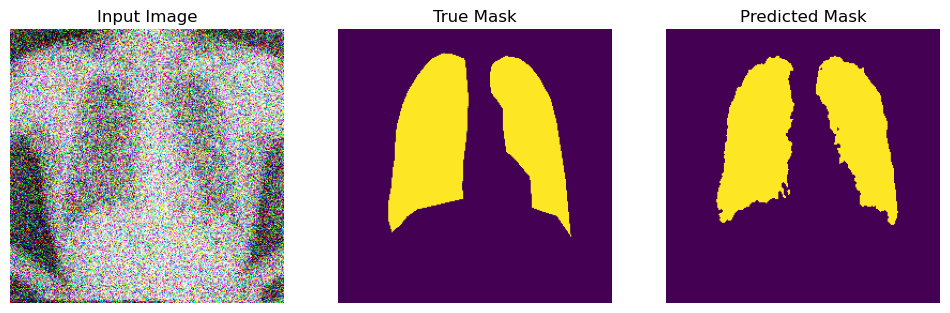

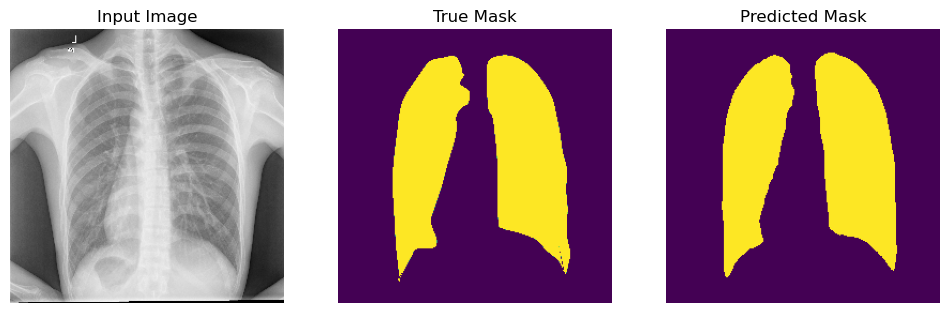

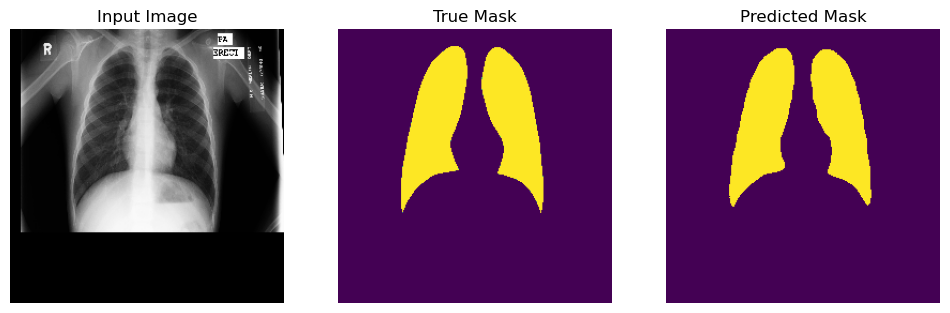

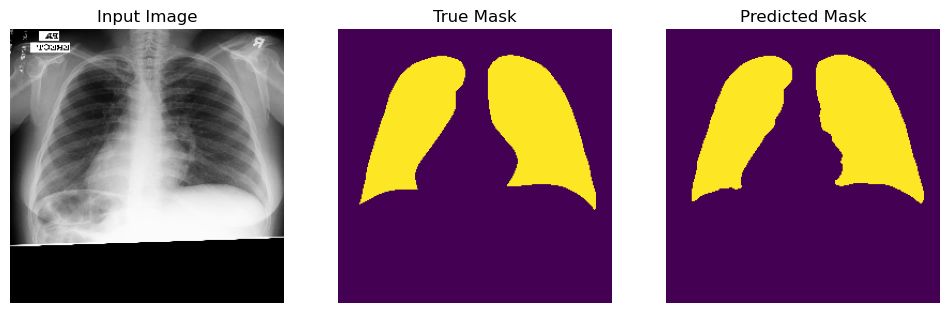

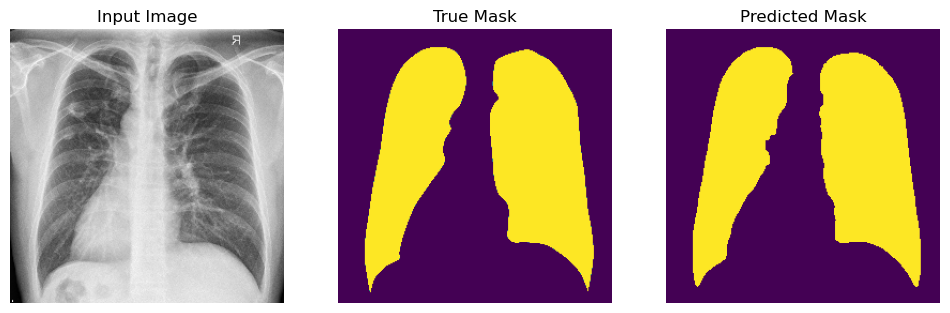

2025-05-13 22:58:32.739750: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
# Take one batch from test_ds
for images, masks in test_ds.take(1):
    preds = model.predict(images)
    preds = (preds > 0.5).astype("float32")

    for i in range(5):  # Show first 5 images
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].numpy())
        plt.title("Input Image")
        plt.axis("off")

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].numpy().squeeze(), cmap="viridis")
        plt.title("True Mask")
        plt.axis("off")
        
         # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(preds[i].squeeze(), cmap="viridis")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()